In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
import warnings

In [2]:
# Load data
data = pd.read_csv(os.path.join(".", 'alzheimers_disease_data.csv'))

data = data.drop(columns=['DoctorInCharge'])

In [3]:

# Normalize features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['Diagnosis']))

# Separate features and targets
X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

# Initialize dictionaries for results and models
results = {}
model_rules = {}
models = {}

In [4]:
# Add KNN models for k=2 to k=10
for k in range(2, 11):
    models[f"KNN_k={k}"] = KNeighborsClassifier(n_neighbors=k)

# Add SVM models with different kernels
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    models[f"SVM_{kernel}"] = SVC(kernel=kernel, probability=True)

# Add Naive Bayes
models["NaiveBayes"] = GaussianNB()

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
    # Train and evaluate models
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Save performance metrics
        results[model_name] = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred, pos_label=1),
            "Precision": precision_score(y_test, y_pred, pos_label=1),
            "F1 Score": f1_score(y_test, y_pred, pos_label=1),
            "Classification Report": classification_report(y_test, y_pred, output_dict=True)
        }

        # Save rules
        if model_name.startswith("KNN"):
            knn_neighbors = model.kneighbors(X_test, return_distance=True)
            model_rules[model_name] = [
                {
                    "Test_Instance_Index": i,
                    "Nearest_Neighbors_Indices": neighbors.tolist(),
                    "Distances": distances.tolist(),
                    "Predicted_Class": model.predict([X_test.iloc[i]])[0]
                }
                for i, (distances, neighbors) in enumerate(zip(*knn_neighbors))
            ]
        elif model_name.startswith("SVM"):
            model_rules[model_name] = {
                "Support_Vectors": model.support_vectors_.tolist(),
                "Coefficients": model.dual_coef_.tolist(),
                "Intercept": model.intercept_.tolist()
            }
        elif model_name == "NaiveBayes":
            model_rules[model_name] = {
                "Class_Priors": model.class_prior_.tolist(),
                "Class_Means": {f"Class_{i}": means.tolist() for i, means in enumerate(model.theta_)},
                "Class_Variances": {f"Class_{i}": vars.tolist() for i, vars in enumerate(model.var_)}
            }

In [6]:
# Save rules to JSON
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

In [7]:
def plot_confusion_matrix(y_true, y_pred, model_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.savefig(f"{model_name}_confusion_matrix.svg", format="svg")

In [8]:
# Save results to JSON
with open("model_results.json", "w") as f:
    json.dump(results, f, indent=4)

In [9]:
serializable_rules = convert_to_serializable(model_rules)
with open("model_rules.json", "w") as f:
    json.dump(serializable_rules, f, indent=4)

In [10]:
# Save comparison table to Excel
results_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [res["Accuracy"] for res in results.values()],
    "Recall": [res["Recall"] for res in results.values()],
    "Precision": [res["Precision"] for res in results.values()],
    "F1 Score": [res["F1 Score"] for res in results.values()]
})
results_df.to_excel("comparison_results.xlsx", index=False)

# Visualize confusion matrix and decision boundaries
labels = ["Benign", "Malignant"]

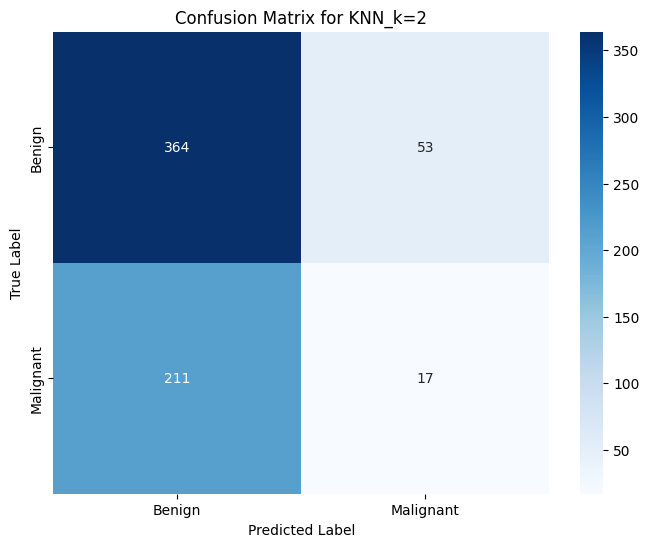

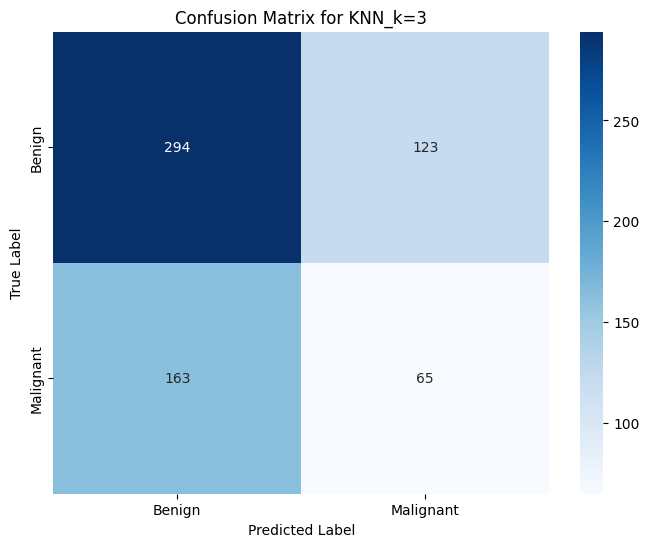

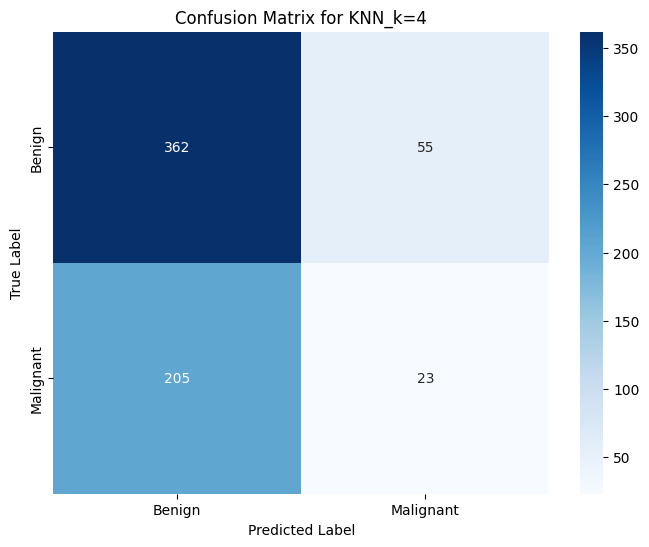

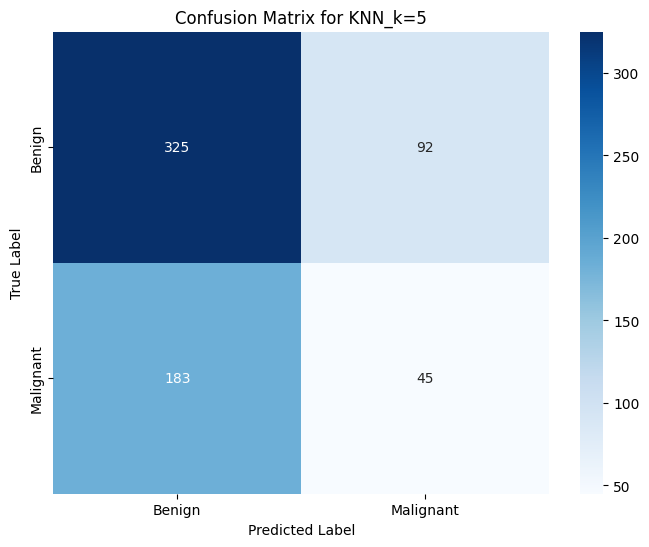

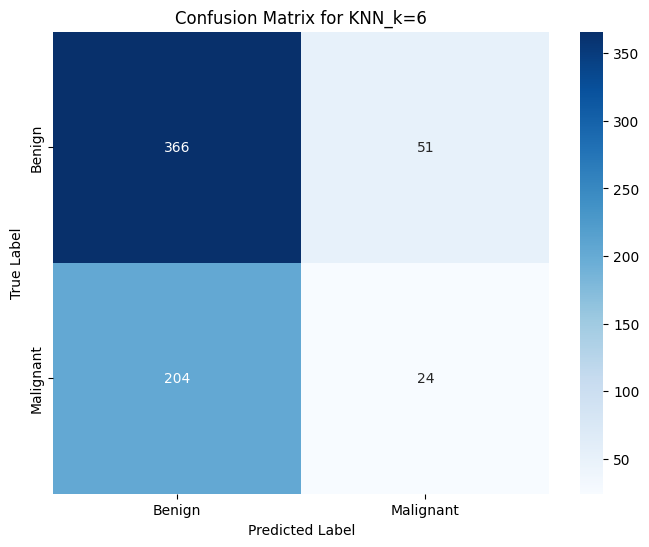

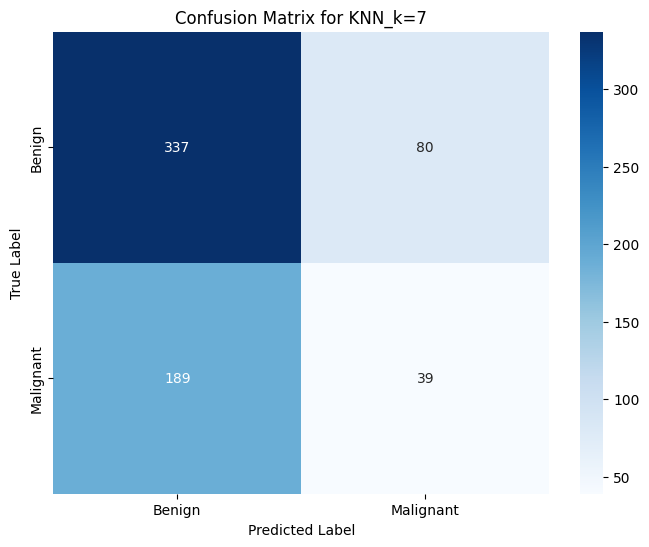

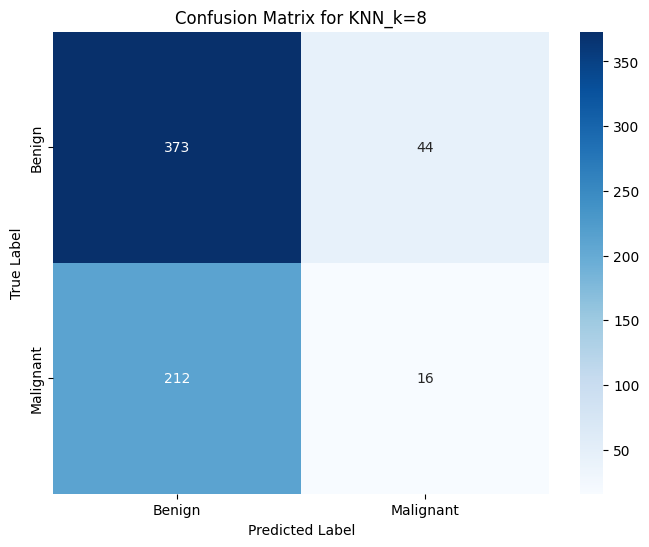

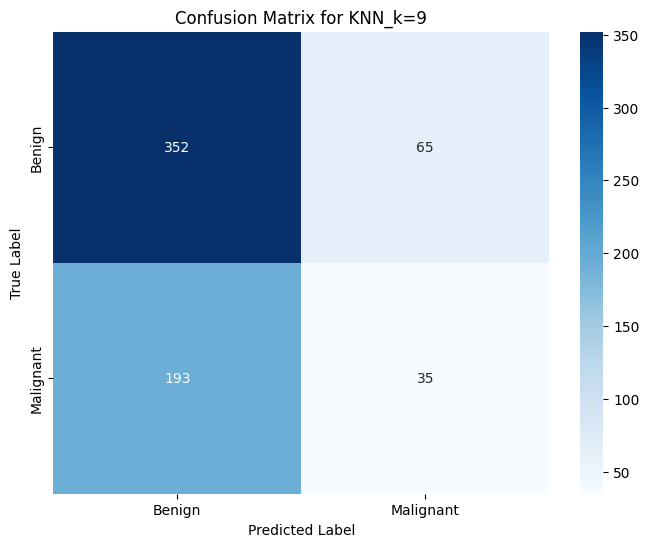

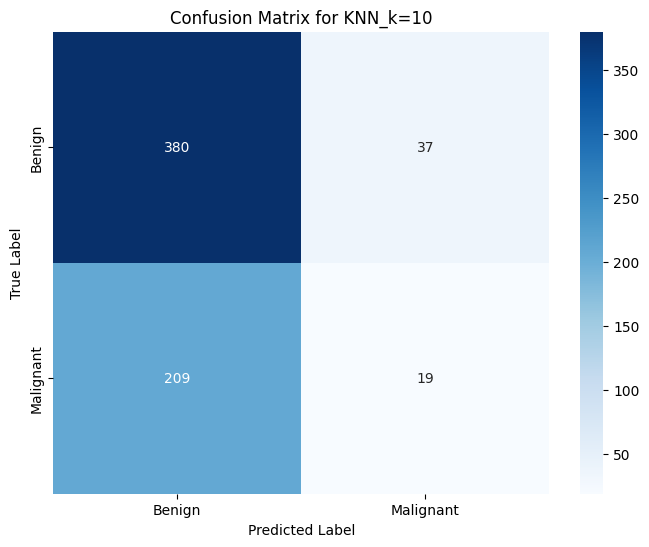

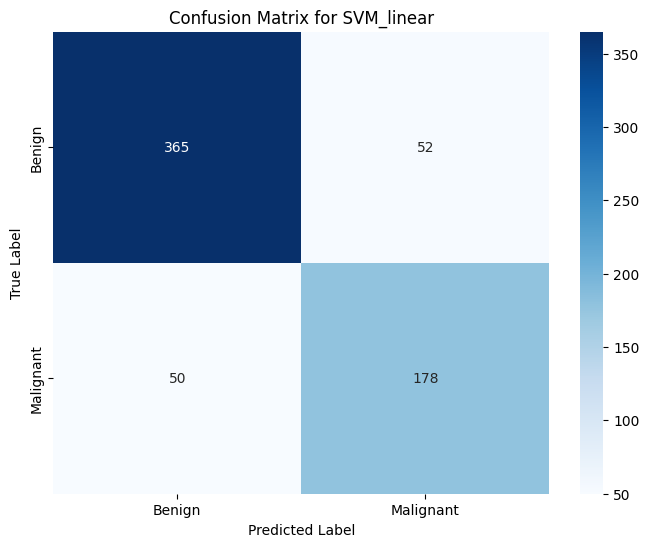

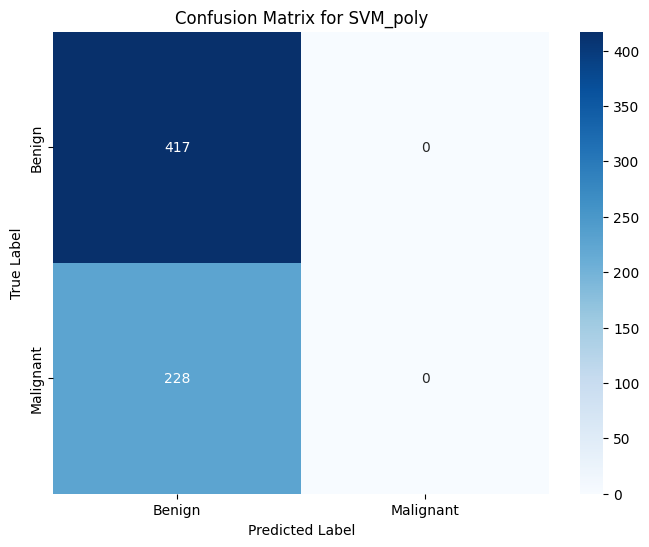

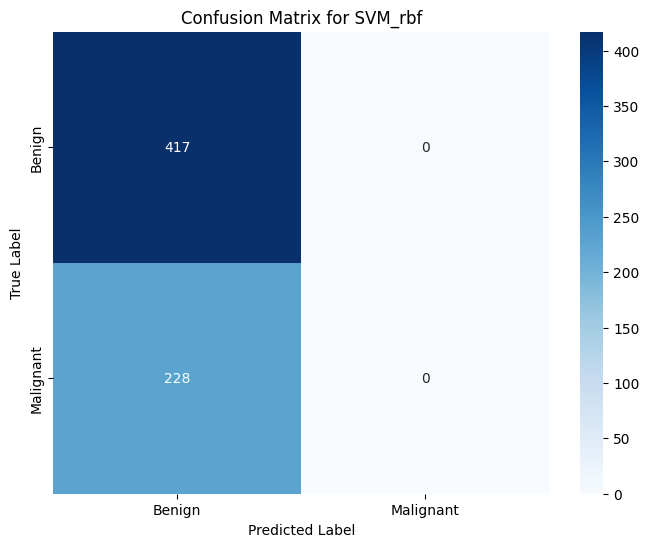

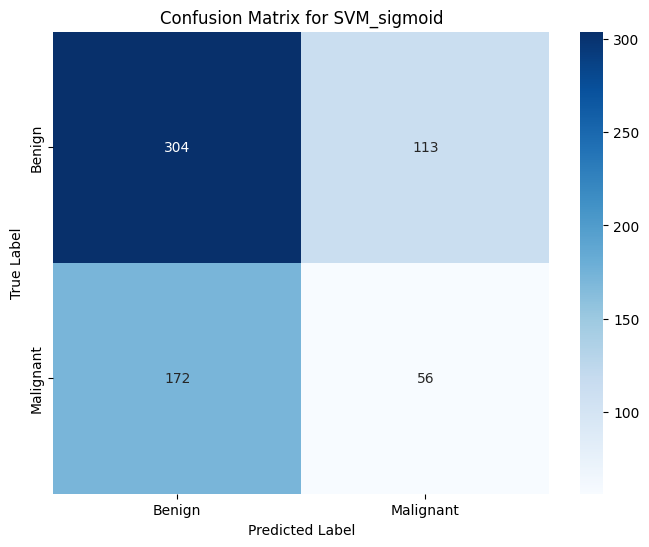

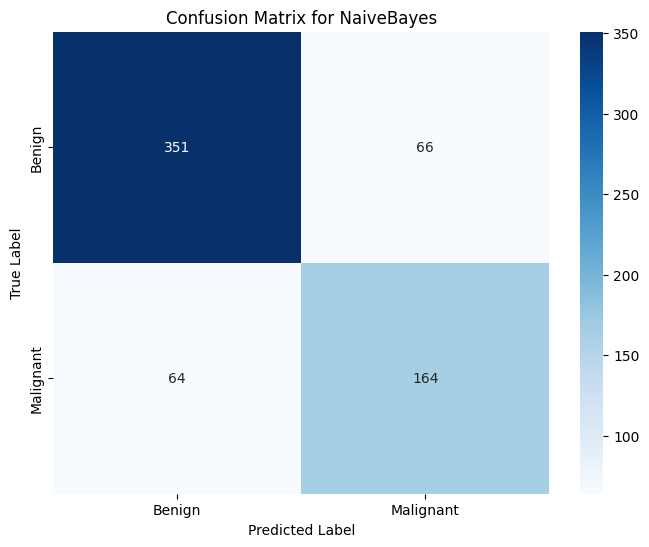

In [11]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Plot decision boundary for 2D data
    if X_test.shape[1] == 2:
        try:
            plot_decision_regions(X_test.values, y_test.values, clf=model, legend=2)
            plt.title(f"Decision Boundary for {model_name}")
            plt.savefig(f"{model_name}_decision_boundary.svg", format="svg")
        except Exception as e:
            print(f"Could not plot decision boundary for {model_name}: {e}")